### **Import libraries**

In [24]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

In [25]:
# Import your functions from fetch_data.py
from fetch_data import fetch_housing_data, load_housing_data
# Download and extract data if not done already
fetch_housing_data()
# Load the housing data into a pandas DataFrame
housing = load_housing_data()

Data already downloaded and extracted.


### 🔍 **Take a Quick Look at the Data Structure**

Let’s begin by examining the top five rows using the DataFrame’s `head()` method.  
Each row in the dataset represents a district in California.


#### 📌 **There are 10 attributes in the dataset:**

- `longitude`  
- `latitude`  
- `housing_median_age`  
- `total_rooms`  
- `total_bedrooms`  
- `population`  
- `households`  
- `median_income`  
- `median_house_value`  
- `ocean_proximity`  


The `info()` method provides a quick summary of the dataset, including:
- The total number of entries (rows)
- Data types of each column
- The number of non-nul


In [26]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [27]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [28]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


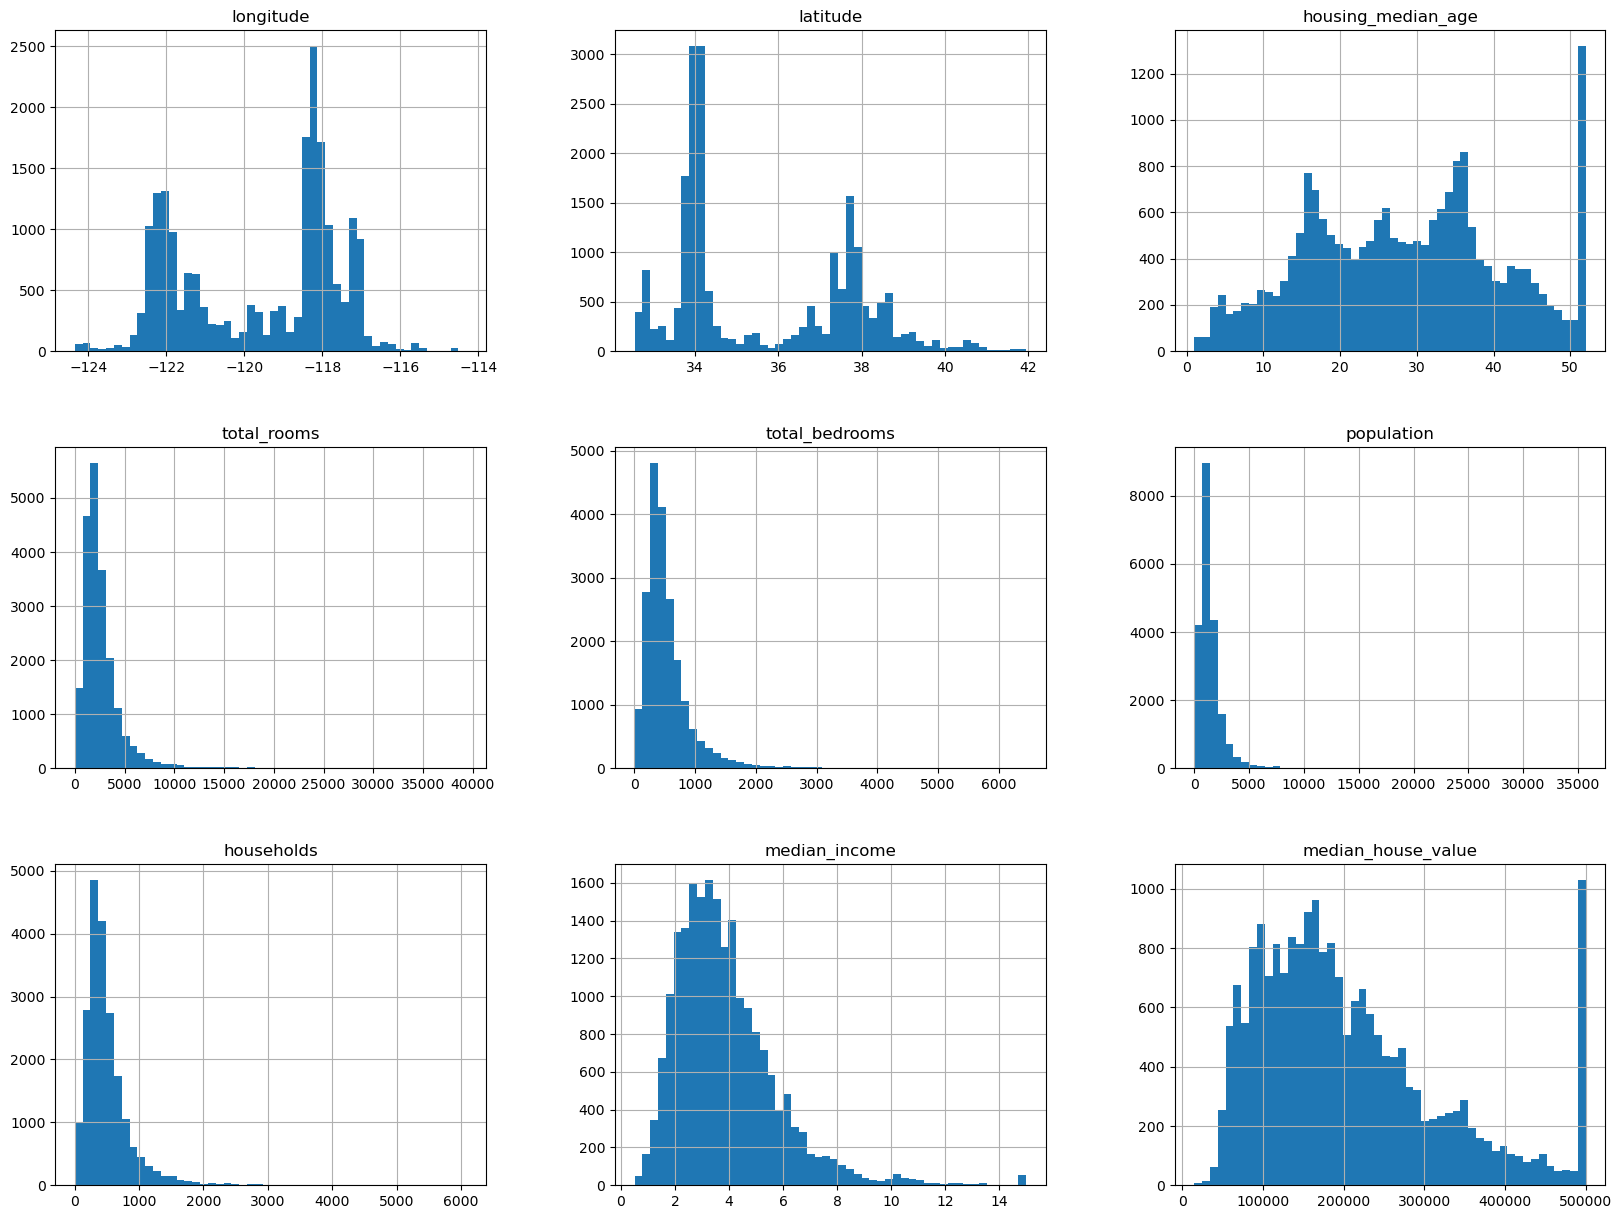

In [29]:
%matplotlib inline
# only in a Jupyter notebook

housing.hist(bins=50, figsize=(20,15))
plt.show()

### Notice a few things in these histograms:

1. **Median Income Scale**  
   The `median_income` attribute does not appear to be expressed in US dollars (USD).  
   After checking with the data collection team, you learn that:
   - The data has been **scaled** and **capped** at **15.0001** for high incomes and at **0.4999** for low incomes.
   - The values represent **tens of thousands of dollars** (e.g., `3` ≈ `$30,000`).

   > 📌 Working with preprocessed attributes is common in Machine Learning.  
   > It's not always an issue, but understanding how the data was processed is important.

2. **Capped Values: Housing Median Age and Median House Value**  
   - These features were also **capped**.
   - Capping the **median house value** may be a serious issue since it is the **target attribute** (label).
   - If the ML algorithm sees only values below a certain threshold (e.g., \$500,000), it may **learn incorrectly** that values never exceed this.

   #### What to do if precise predictions > \$500,000 are needed?
   - **Option 1**: Collect **uncapped labels** for those districts.
   - **Option 2**: Remove those districts from the **training and test sets** so the model is not unfairly penalized.

3. **Different Feature Scales**  
   - The features have very **different scales** (e.g., income vs. housing age).
   - This will require **feature scaling**, which we'll explore later in this chapter.

4. **Tail-Heavy Distributions**  
   - Many histograms are **right-skewed** (tail heavy).
   - This makes it harder for some ML algorithms to **detect patterns**.


### 🧪 **Create a Test Set**

It may seem strange to set aside part of the data before diving deeper into analysis.  
After all, shouldn’t we learn more about the data first?

However:

> ⚠️ **Your brain is an amazing pattern detection system, and that makes it prone to overfitting.**

If you examine the test set early, you may notice patterns and **subconsciously overfit** your model.  
This leads to **data snooping bias**: your system performs well in testing, but poorly in the real world.

#### ✅ **Best Practice:**

Create a test set **right away**:

- Pick a random subset of the data — typically **20%** (or less if the dataset is large)
- Set it aside and **never look at it** until the final evaluation stage



In [30]:
def split_train_data(data , test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices] , data.iloc[test_indices]

In [31]:
train_set , test_set = split_train_data(housing , 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [32]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9508,-122.65,38.01,40.0,1428.0,280.0,708.0,255.0,5.0766,305400.0,NEAR OCEAN
15580,-117.12,32.57,35.0,1450.0,256.0,930.0,286.0,2.6715,133300.0,NEAR OCEAN
7388,-117.00,32.72,10.0,3817.0,943.0,2352.0,875.0,2.1362,143200.0,NEAR OCEAN
12445,-122.42,37.77,52.0,1086.0,349.0,589.0,361.0,2.5186,250000.0,NEAR BAY
1119,-122.30,37.90,41.0,2053.0,435.0,873.0,415.0,3.4091,223000.0,NEAR BAY


In [33]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4746,-122.73,38.46,14.0,4042.0,1298.0,2323.0,1158.0,2.0651,135400.0,<1H OCEAN
9195,-119.37,36.47,26.0,337.0,69.0,277.0,73.0,2.3438,100000.0,INLAND
906,-119.29,34.28,38.0,2387.0,748.0,1537.0,741.0,2.3147,192500.0,NEAR OCEAN
3732,-119.99,38.88,17.0,2807.0,529.0,675.0,251.0,2.7457,107800.0,INLAND
7955,-122.77,38.39,35.0,2611.0,475.0,1293.0,463.0,2.7500,197500.0,<1H OCEAN


In [34]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### 🎯 **Reliable & Representative Test Set Creation , Stratified Sampling**

Splitting the dataset randomly can cause the test set to have skewed proportions of key categories. Stratified sampling divides the data into subgroups (strata) and samples proportionally from each, preserving the overall distribution in the test set.

#### 🎯 **Why Stratified Sampling?**

Purely random sampling usually works well with large datasets. However, if the dataset is small or some features are unevenly distributed, random sampling may produce **biased samples**.

For example, in a survey of 1,000 people, the US population is roughly 51.3% female and 48.7% male. A well-designed survey maintains this ratio to get **representative results**. Pure random sampling could result in skewed gender ratios in the sample, biasing the outcomes.

This approach of dividing the population into **homogeneous subgroups (strata)** and sampling proportionally from each is called **stratified sampling**. It ensures the test set reflects the overall population accurately.


#### 🏷️ **Creating Income Categories for Stratification**

If a numerical feature like **median income** is crucial for prediction, you can turn it into a categorical attribute to stratify by income level.

Using `pd.cut()`, the continuous median income is split into 5 categories representing income ranges:

- Category 1: 0 to 1.5 (less than $15,000)  
- Category 2: 1.5 to 3  
- Category 3: 3 to 4.5  
- Category 4: 4.5 to 6  
- Category 5: 6 and above

This helps ensure the train and test sets maintain similar distributions of income levels.



#### 🧪 **Train-Test Split with Stratified Sampling**

To ensure the test set represents the overall population well—especially for imbalanced categories—we used **Stratified Sampling** via `Scikit-Learn`.

- The `ocean_proximity` feature is categorical and location-based, making it a good candidate for stratified sampling.
- To stratify on income, we created an `income_cat` attribute using the `median_income` feature.


In [35]:
housing['income_cat'] = pd.cut(housing['median_income'] , bins=[0.,1.5,3.0,4.5,6. , np.inf] , labels=[1,2,3,4,5])

In [36]:
housing['income_cat'].hist()

<Axes: >

In [37]:
split = StratifiedShuffleSplit(n_splits=1 , test_size=0.2 , random_state=42)
for train_index , test_index in split.split(housing , housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

- Let’s see if this worked as expected. You can start by looking at the income category
proportions in the test set:

In [38]:
strat_test_set.income_cat.value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

* We then performed a **Stratified Shuffle Split** to maintain the `income_cat` distribution in both training and test sets.

After the split, we removed the `income_cat` column to restore the datasets to their original state:


In [39]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [40]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


### 🔍 Next Step: Data Exploration

With a properly split dataset, we now begin **exploring the data** to gain insights and prepare it for the machine learning pipeline.


In [41]:
housing = strat_train_set.copy()

### 📍 **Visualizing Geographical Data**

We have **geographical information**—specifically `latitude` and `longitude`. Plotting these as a scatterplot helps visualize **district locations** on the map.

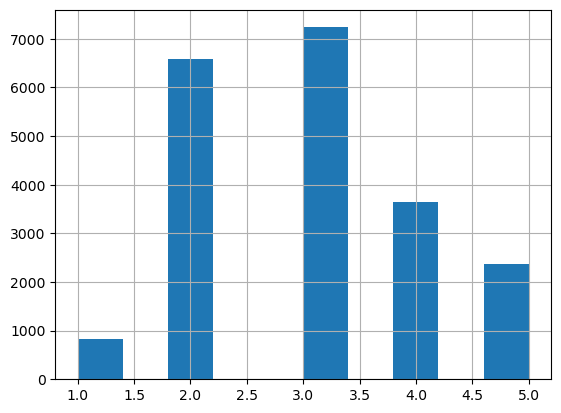

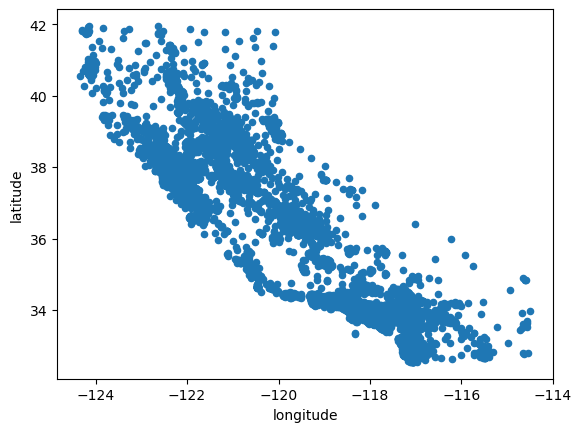

In [42]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

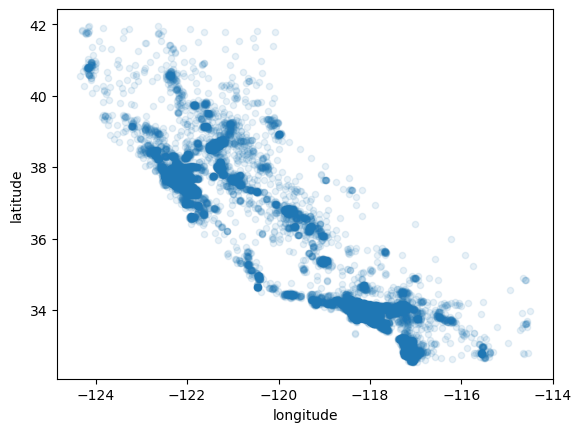

In [43]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

### 🌍 **Visualizing Geographical Data with Housing Prices**

Now that we have a basic scatter plot of the districts using longitude and latitude, we can improve the visualization by adding more dimensions to the plot:

- **Circle radius** will represent the population of each district.
- **Color** will represent the median house value.
- We'll use the `jet` colormap (`cmap='jet'`) which ranges from blue (low) to red (high prices).

This enhanced scatter plot helps us spot geographic patterns in housing prices and population distribution more effectively.

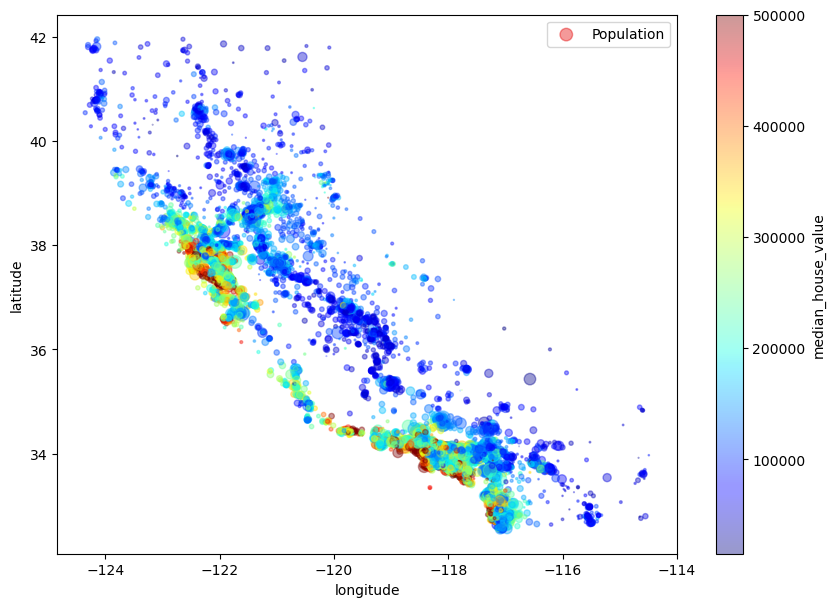

In [44]:
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4,
    s=housing["population"] / 100,  # radius of circle
    label="Population",
    c="median_house_value",         # color represents house value
    cmap=plt.get_cmap("jet"),       # color map
    colorbar=True,
    figsize=(10,7)
)
plt.show()